In [1]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import cv2
import numpy as np
from torchvision import datasets, transforms

import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable


c:\Users\HZT\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

all_sample=pd.read_csv("all_sample.csv")
negative_data=all_sample[all_sample["type"]=="not_fit"]
postive_data=all_sample[all_sample["type"]=="fit"]


#訓練2500 測試500
train_P=postive_data.sample(3000,random_state=178)
train_N=negative_data.sample(3000,random_state=198)
test_P=train_P.sample(500,random_state=73)
test_N=train_N.sample(500,random_state=65)

train_P=train_P.drop(test_P.index)
train_N=train_N.drop(test_N.index)

train_P=train_P.sort_values(by=["source","target"]).reset_index(drop=True)
train_N=train_N.sort_values(by=["source","target"]).reset_index(drop=True)
test_P=test_P.sort_values(by=["source","target"]).reset_index(drop=True)
test_N=test_N.sort_values(by=["source","target"]).reset_index(drop=True)

In [3]:

transform=transforms.Compose([
    transforms.Resize(224), #缩放图片，保持长宽比不变，最短边的长为224像素,
    #transforms.CenterCrop([150,224]), #从中间切出 150*224的图片
])


In [4]:
imgs=os.listdir("OB_imgs")
pbar=tqdm(total=len(imgs))
for img in imgs:
    path="OB_imgs/"+img
    pil_img=Image.open(path)
    ttt=transform(pil_img)
    save_dir="no_crop_img_test/"+img
    ttt.save(save_dir)
    pbar.update(1)

pbar.close()
    

100%|██████████| 17000/17000 [09:53<00:00, 28.66it/s]


In [5]:
def v_merge_img(data_df):
    source=list(data_df["source"])
    target=list(data_df["target"])
    type=list(data_df["type"])[0]
    if(len(data_df)==2500 and type=="fit"):
        folder_name="noc_train/fit"
    elif(len(data_df)==2500 and type=="not_fit"):
        folder_name="noc_train/not_fit"
    elif(len(data_df)==500 and type=="fit"):
        folder_name="noc_test/fit"
    elif(len(data_df)==500 and type=="not_fit"):
        folder_name="noc_test/not_fit"

    if (os.path.exists(folder_name)==False):
        os.mkdir(folder_name)

    for i,top in enumerate(source):
        top_dir="no_crop_img_test/"+top+".png"
        bottom_dir="no_crop_img_test/"+target[i]+".png"
        
        top_img = cv2.imread(top_dir)
        bottom_img = cv2.imread(bottom_dir)
        fit_img = np.vstack([top_img, bottom_img])  # 垂直拼接

        fit_img_dir=folder_name+"/fit"+str(i)+".png"
        cv2.imwrite(fit_img_dir,fit_img)
        
   


In [6]:
v_merge_img(test_P)
v_merge_img(test_N)

v_merge_img(train_P)
v_merge_img(train_N)


In [7]:
transform2=transforms.Compose([
    transforms.Resize([224,224]), #缩放图片，保持长宽比不变，最短边的长为224像素,
    transforms.ToTensor(), #将图片转换为Tensor,归一化至[0,1]
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]) #标准化至[-1,1]
])

batch_size=16

train_dir = "train"           
#定義數據集
train_datasets = datasets.ImageFolder(train_dir, transform=transform2)
#加載數據集
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)

val_dir = "test"		
val_datasets = datasets.ImageFolder(val_dir, transform=transform2)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=False)

In [8]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=False)
        net.classifier = nn.Sequential()
        self.features = net
        self.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, 128),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
learning_rate = 5e-5
epoch = 20

model = VGGNet()
if torch.cuda.is_available():
    model.cuda()
params = [{'params': md.parameters()} for md in model.children()
          if md in [model.classifier]]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

model.train()

loss_list = []
accuracy_list = []
tr_loss_list = []
tr_accuracy_list = []

for i in range(epoch):
    print('epoch {}'.format(i + 1))
    train_loss = 0.
    train_acc = 0.
    pbar=tqdm(total=len(train_dataloader))
    for img, label in train_dataloader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output, label)
        train_loss += loss.item()
        pred = torch.max(output, 1)[1]
        train_correct = (pred == label).sum()
        train_acc += train_correct.item()
        loss.backward()
        optimizer.step()
        pbar.update(1)
    pbar.close()

    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(train_datasets)), train_acc / (len(train_datasets))))
    tr_loss_list.append(train_loss / (len(train_datasets)))
    tr_accuracy_list.append(100 * train_acc / (len(train_datasets)))

    # evaluation--------------------------------
    model.eval()
    eval_loss = 0.
    eval_acc = 0.
    for img, label in val_dataloader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        out = model(img)
        loss = loss_func(out, label)
        eval_loss += loss.item()
        pred = torch.max(out, 1)[1]
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(val_datasets)), eval_acc / (len(val_datasets))))
    loss_list.append(eval_loss / (len(val_datasets)))
    accuracy_list.append(100 * eval_acc / (len(val_datasets)))

c:\Users\HZT\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\HZT\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch 1


100%|██████████| 313/313 [00:28<00:00, 10.82it/s]


Train Loss: 0.043427, Acc: 0.510600
Test Loss: 0.043660, Acc: 0.500000
epoch 2


100%|██████████| 313/313 [00:26<00:00, 11.81it/s]


Train Loss: 0.043337, Acc: 0.520200
Test Loss: 0.043026, Acc: 0.606000
epoch 3


100%|██████████| 313/313 [00:26<00:00, 11.76it/s]


Train Loss: 0.038327, Acc: 0.661400
Test Loss: 0.030502, Acc: 0.757000
epoch 4


100%|██████████| 313/313 [00:26<00:00, 11.75it/s]


Train Loss: 0.026523, Acc: 0.801600
Test Loss: 0.022486, Acc: 0.825000
epoch 5


100%|██████████| 313/313 [00:26<00:00, 11.73it/s]


Train Loss: 0.020892, Acc: 0.851000
Test Loss: 0.023868, Acc: 0.846000
epoch 6


100%|██████████| 313/313 [00:26<00:00, 11.70it/s]


Train Loss: 0.018134, Acc: 0.876400
Test Loss: 0.022090, Acc: 0.855000
epoch 7


100%|██████████| 313/313 [00:26<00:00, 11.69it/s]


Train Loss: 0.016035, Acc: 0.887600
Test Loss: 0.020873, Acc: 0.841000
epoch 8


100%|██████████| 313/313 [00:26<00:00, 11.69it/s]


Train Loss: 0.012892, Acc: 0.913400
Test Loss: 0.017016, Acc: 0.887000
epoch 9


100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Train Loss: 0.009938, Acc: 0.936800
Test Loss: 0.016747, Acc: 0.894000
epoch 10


100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Train Loss: 0.007253, Acc: 0.953200
Test Loss: 0.019375, Acc: 0.892000
epoch 11


100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Train Loss: 0.005594, Acc: 0.967200
Test Loss: 0.020201, Acc: 0.903000
epoch 12


100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Train Loss: 0.003910, Acc: 0.978800
Test Loss: 0.030319, Acc: 0.887000
epoch 13


100%|██████████| 313/313 [00:26<00:00, 11.69it/s]


Train Loss: 0.003558, Acc: 0.978800
Test Loss: 0.025057, Acc: 0.912000
epoch 14


100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Train Loss: 0.003129, Acc: 0.984600
Test Loss: 0.021015, Acc: 0.911000
epoch 15


100%|██████████| 313/313 [00:26<00:00, 11.69it/s]


Train Loss: 0.002483, Acc: 0.985800
Test Loss: 0.020712, Acc: 0.899000
epoch 16


100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Train Loss: 0.001510, Acc: 0.992400
Test Loss: 0.028141, Acc: 0.889000
epoch 17


100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Train Loss: 0.001537, Acc: 0.993000
Test Loss: 0.024782, Acc: 0.906000
epoch 18


100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Train Loss: 0.001234, Acc: 0.994800
Test Loss: 0.026825, Acc: 0.909000
epoch 19


100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Train Loss: 0.001635, Acc: 0.991800
Test Loss: 0.023379, Acc: 0.909000
epoch 20


100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Train Loss: 0.001442, Acc: 0.993400
Test Loss: 0.028754, Acc: 0.895000


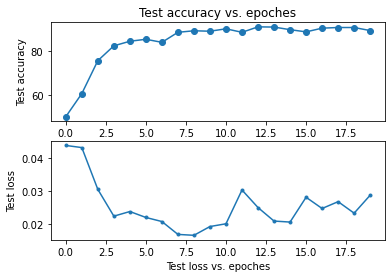

In [10]:
import matplotlib.pyplot as plt

x1 = range(0, 20)
x2 = range(0, 20)
y1 = accuracy_list
y2 = loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()
# plt.savefig("accuracy_loss.jpg")


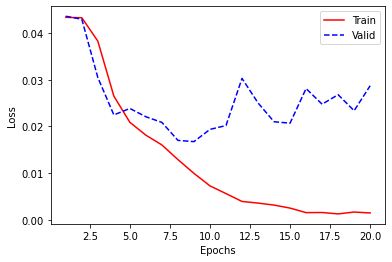

In [11]:
#distplot
import matplotlib.pyplot as plt
epochs =[i+1 for i in range(20)]
plt.plot(epochs,tr_loss_list, color='red', label='Train')
plt.plot(epochs,loss_list, '--', color='blue', label='Valid')
#plt.title('CrossEntropy') # title
plt.ylabel("Loss") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
#plt.savefig('.\\Model\\0618\\t_model_' + str(isbalence) + 'bz' + str(batch_sizes) + '_' + str(num_epochs) + '.png') #儲存圖檔
#plt.savefig('.\\Model\\0618\\實驗' + str(testnum) + '.png') #儲存圖檔
plt.show()

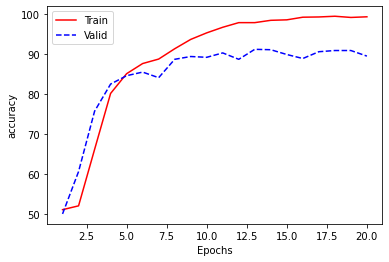

In [12]:
#distplot
import matplotlib.pyplot as plt
epochs =[i+1 for i in range(20)]
plt.plot(epochs,tr_accuracy_list, color='red', label='Train')
plt.plot(epochs,accuracy_list, '--', color='blue', label='Valid')
#plt.title('CrossEntropy') # title
plt.ylabel("accuracy") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
#plt.savefig('.\\Model\\0618\\t_model_' + str(isbalence) + 'bz' + str(batch_sizes) + '_' + str(num_epochs) + '.png') #儲存圖檔
#plt.savefig('.\\Model\\0618\\實驗' + str(testnum) + '.png') #儲存圖檔
plt.show()

In [13]:
torch.save(model.state_dict(), "VGG16_0809_ncrop.pt")
